In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import RobustScaler

# Load dataset
df = pd.read_csv('f1_2019_to_2023_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'
df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df = pd.get_dummies(df, columns=['Weather_Category'])


# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013, 53.02449646], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High','VERY_High'])
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus','Circuit'])
# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']
df.drop(columns=columns_to_drop, inplace=True)



## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]


def remove_outliers(df, column_name, multiplier=1.5):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Apply standard IQR for dry days
df_dry_filtered = remove_outliers(df_dry, 'LapTime', multiplier=1.5)

# Apply a more lenient IQR for wet days
df_wet_filtered = remove_outliers(df_wet, 'LapTime', multiplier=2.0)


df_combined = pd.concat([df_dry_filtered, df_wet_filtered], ignore_index=True)


# Define features and target
X = df_combined.drop('LapTime', axis=1)
y = df_combined['LapTime']

# stratify with Rainfall to handle imbalance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop rows where the target variable is missing in the training set
train_indices = y_train.dropna().index  # Indices of rows where y_train is not NaN
X_train = X_train.loc[train_indices]
y_train = y_train.dropna()  # Drop missing values in y_train



numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']

from sklearn.impute import SimpleImputer

# Imputer for numeric features
imputer = SimpleImputer(strategy='median')  # robust to outliers

X_train[numeric_features] = imputer.fit_transform(X_train[numeric_features])
X_test[numeric_features] = imputer.transform(X_test[numeric_features])

# Optional: Impute missing target values in the training set if necessary
# It's generally better to drop rows with missing target variables
y_train.fillna(method='ffill', inplace=True)  # Forward fill might be used if appropriate



scaler = RobustScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


from sklearn.preprocessing import StandardScaler

# Standardize the features (mean = 0 and variance = 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/var/folders/_5/533f3cq93vq25vl2f3txpkb40000gn/T/ipykernel_29704/25339490.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_train.fillna(method='ffill', inplace=True)  # Forward fill might be used if appropriate


In [9]:
from sklearn.decomposition import PCA

# Initialize PCA, let's say we try to keep 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components used
print("Number of PCA components:", pca.n_components_)


Number of PCA components: 95


In [10]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


##BASE XG BOOST

#Grid value : (n_estimators=700, learning_rate=0.1,random_state=42,n_jobs=-1,max_depth=7)

# Train the model with class weight adjustment
xgb_model = XGBRegressor(random_state=42,n_estimators= 500,max_depth=7,learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
predictions = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Baseline RMSE for Combined df: {rmse}")

from sklearn.model_selection import cross_val_score

# Evaluate with K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)  # Convert MSE to RMSE
print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Baseline RMSE for Combined df: 1.4866772732475524
Cross-validated RMSE scores: [1.66380866 1.67023949 1.58082324 1.54360558 1.59096764]
Mean RMSE: 1.6098889206770859


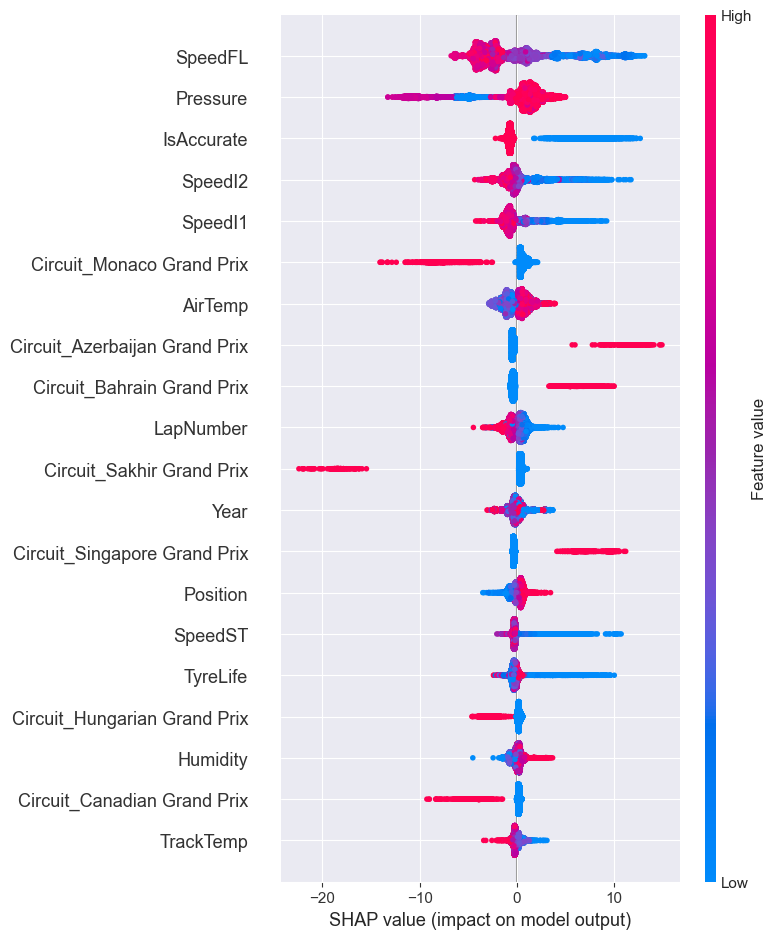

In [11]:
import shap

# Use SHAP to explain feature importance
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)